### Importing packages and defining data set paths

In [104]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import pymannkendall as mk

In [83]:
data_dir = '/Users/aleksandra/Documents/environmental_data_project_1/'

datasets = {
    "CO_data": 'CO_1g_joint_2017-2023.csv',
    "NOx_data": 'NOx_1g_joint_2017-2023.csv',
    "PM10_data": 'PM10_1g_joint_2017-2023.csv',
    "PM25_data": 'PM25_1g_joint_2017-2023.csv',
    "SO2_data": 'SO2_1g_joint_2017-2023.csv'
}

### Data pre-processing

In [84]:
for name, file in datasets.items():
    data = pd.read_csv(data_dir + file)
    print(f"{name} shape: {data.shape}")

CO_data shape: (61345, 114)
NOx_data shape: (61345, 220)
PM10_data shape: (61345, 273)
PM25_data shape: (61345, 161)
SO2_data shape: (61345, 170)


In [85]:
for name, file in datasets.items():
    data = pd.read_csv(data_dir + file)
    
    # Filter columns that contain 'Krak' which stands for Krakow, a city in the south of Poland
    krak_columns = [col for col in data.columns if 'Krak' in col]
    
    if krak_columns:
        print(f"\nIn {name}, columns containing 'Krak':")
        for col in krak_columns:
            missing_count = data[col].isna().sum()
            print(f"  {col}: {missing_count} missing values")
    else:
        print(f"\nIn {name}, no columns containing 'Krak'.")


In CO_data, columns containing 'Krak':
  MpKrakAlKras-CO-1g: 9491 missing values
  MpKrakBulwar-CO-1g: 1046 missing values

In NOx_data, columns containing 'Krak':
  MpKrakAlKras-NOx-1g: 9383 missing values
  MpKrakBujaka-NOx-1g: 1581 missing values
  MpKrakBulwar-NOx-1g: 1201 missing values
  MpKrakDietla-NOx-1g: 522 missing values

In PM10_data, columns containing 'Krak':
  MpKrakAlKras-PM10-1g: 9411 missing values
  MpKrakBujaka-PM10-1g: 1816 missing values
  MpKrakBulwar-PM10-1g: 999 missing values
  MpKrakDietla-PM10-1g: 1300 missing values
  MpKrakOsPias-PM10-1g: 2844 missing values
  MpKrakTelime-PM10-1g: 49135 missing values
  MpKrakWadow-PM10-1g: 889 missing values
  MpKrakZloRog-PM10-1g: 1263 missing values
  MpKrakSwoszo-PM10-1g: 18885 missing values

In PM25_data, columns containing 'Krak':
  MpKrakAlKras-PM2.5-1g: 9407 missing values
  MpKrakBujaka-PM2.5-1g: 35740 missing values
  MpKrakBulwar-PM2.5-1g: 1000 missing values

In SO2_data, columns containing 'Krak':
  MpKrak

We see that AlKras, Bulwar and Bujaka are the most commonly found weather stations. Now:  
- AlKras is missing from SO2_data
- Bujaka has too many missing values in PM25_data (more than half).

I suggest we consider Bulwar, and for the second one either AlKras (but without SO2_data) or Bujaka (but without PM25_data).  

__Let's try AlKras and Bulwar on CO_data, NOx_data, PM10_data and PM25_data.__

In [86]:
datasets_of_interest = ["CO_data", "NOx_data", "PM10_data", "PM25_data"]
results = []

for name in datasets_of_interest:
    file = datasets[name]
    data = pd.read_csv(data_dir + file)
    
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    if krak_columns:
        for col in krak_columns:
            missing_count = data[col].isna().sum()
            total_count = len(data[col])
            
            percentage_missing = (missing_count / total_count) * 100 if total_count > 0 else 0
            
            results.append({
                "Dataset": name,
                "Column": col,
                "Missing Values": missing_count,
                "Percentage": f"{percentage_missing:.2f}%"
            })
    
results_df = pd.DataFrame(results)

if not results_df.empty:
    print(results_df)
else:
    print("No columns containing 'MpKrakAlKras' or 'MpKrakBulwar' found in the specified datasets.")

     Dataset                 Column  Missing Values Percentage
0    CO_data     MpKrakAlKras-CO-1g            9491     15.47%
1    CO_data     MpKrakBulwar-CO-1g            1046      1.71%
2   NOx_data    MpKrakAlKras-NOx-1g            9383     15.30%
3   NOx_data    MpKrakBulwar-NOx-1g            1201      1.96%
4  PM10_data   MpKrakAlKras-PM10-1g            9411     15.34%
5  PM10_data   MpKrakBulwar-PM10-1g             999      1.63%
6  PM25_data  MpKrakAlKras-PM2.5-1g            9407     15.33%
7  PM25_data  MpKrakBulwar-PM2.5-1g            1000      1.63%


We see that the missing data percentage is quite low, so since we have really large data sets, we are going to remove all the rows where the values are missing.

In [87]:
for name in datasets_of_interest:
    file = datasets[name]
    data = pd.read_csv(data_dir + file)
    
    # Find columns that contain 'MpKrakAlKras' or 'MpKrakBulwar'
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    if krak_columns:
        # Remove rows where any of the specified columns have NaN values
        cleaned_data = data.dropna(subset=krak_columns)
        
        cleaned_data.to_csv(data_dir + f'cleaned_{name}.csv', index=False)
        
        print(f"Cleaned {name}: {cleaned_data.shape[0]} rows remaining after removing NaN values.")
    else:
        print(f"No columns containing 'MpKrakAlKras' or 'MpKrakBulwar' found in {name}.")

Cleaned CO_data: 50925 rows remaining after removing NaN values.
Cleaned NOx_data: 50999 rows remaining after removing NaN values.
Cleaned PM10_data: 50999 rows remaining after removing NaN values.
Cleaned PM25_data: 50984 rows remaining after removing NaN values.


### Summary statistics

In [88]:
cleaned_datasets = {
    "CO_data": 'cleaned_CO_data.csv',
    "NOx_data": 'cleaned_NOx_data.csv',
    "PM10_data": 'cleaned_PM10_data.csv',
    "PM25_data": 'cleaned_PM25_data.csv',
}

summary_stats_dict = {}

for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_dir + file)
    
    # Find columns that contain 'MpKrakAlKras' or 'MpKrakBulwar'
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    summary_stats = []

    # Calculate summary statistics for each relevant column
    for col in krak_columns:
        stats = data[col].describe()
        summary_stats.append({
            'Statistic': 'Mean', 
            'Value': stats['mean'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Standard deviation', 
            'Value': stats['std'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Min', 
            'Value': stats['min'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': '25th percentile', 
            'Value': stats['25%'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Median', 
            'Value': stats['50%'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': '75th percentile', 
            'Value': stats['75%'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Max', 
            'Value': stats['max'],
            'Column': col
        })

    # Create a DataFrame from the summary statistics
    summary_df = pd.DataFrame(summary_stats)
    summary_df_pivot = summary_df.pivot(index='Statistic', columns='Column', values='Value')
    summary_stats_dict[name] = summary_df_pivot

# Display the summary statistics tables for each dataset
for dataset, stats_table in summary_stats_dict.items():
    print(f"\nSummary Statistics for {dataset}:")
    stats_table.columns.name = ''
    display(stats_table.style
        .set_table_attributes('style="font-size: 12px; border-collapse: collapse; width: 50%;"')
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#f5f5f5'), ('font-weight', 'bold'), ('border', '1px solid #dddddd'), ('max-width', '100px')]},  # Set max-width for headers
            {'selector': 'td', 'props': [('border', '1px solid #dddddd'), ('max-width', '100px')]}  # Set max-width for cells
        ])
    )


Summary Statistics for CO_data:


,MpKrakAlKras-CO-1g,MpKrakBulwar-CO-1g
Statistic,,
25th percentile,0.487550,0.219640
75th percentile,0.891970,0.509820
Max,6.212260,6.416360
Mean,0.755683,0.430141
Median,0.639870,0.330090
Min,0.101120,0.018390
Standard deviation,0.416339,0.349616



Summary Statistics for NOx_data:


,MpKrakAlKras-NOx-1g,MpKrakBulwar-NOx-1g
Statistic,,
25th percentile,83.998500,16.850600
75th percentile,210.207500,56.354600
Max,1340.630000,967.868000
Mean,163.366046,49.881328
Median,137.223000,29.860700
Min,5.672270,2.228540
Standard deviation,115.113106,62.271617



Summary Statistics for PM10_data:


,MpKrakAlKras-PM10-1g,MpKrakBulwar-PM10-1g
Statistic,,
25th percentile,23.565500,15.694200
75th percentile,56.420250,41.663750
Max,415.450000,382.054000
Mean,46.075368,34.109582
Median,35.698100,24.795000
Min,1.000000,1.000000
Standard deviation,36.182031,30.127835



Summary Statistics for PM25_data:


,MpKrakAlKras-PM2.5-1g,MpKrakBulwar-PM2.5-1g
Statistic,,
25th percentile,12.767775,8.588437
75th percentile,35.773450,28.247000
Max,341.088000,329.693000
Mean,29.535831,23.234632
Median,20.896100,15.446300
Min,1.000000,0.900000
Standard deviation,27.756325,24.128311


### Time-series plots

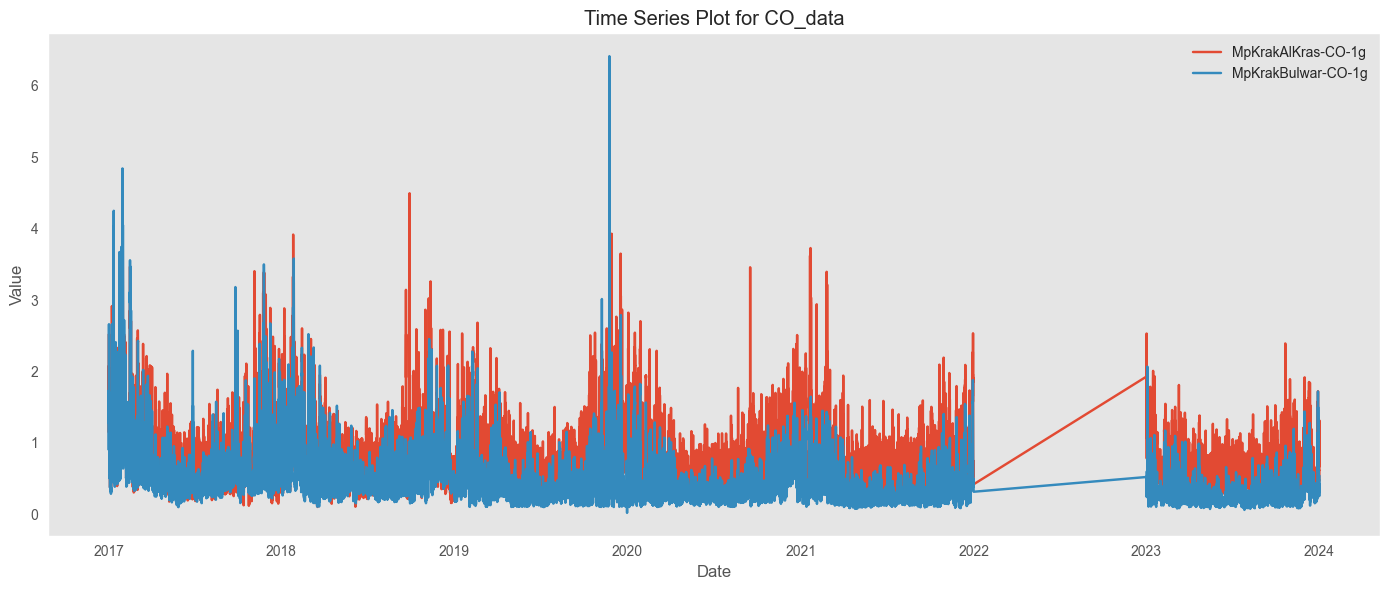

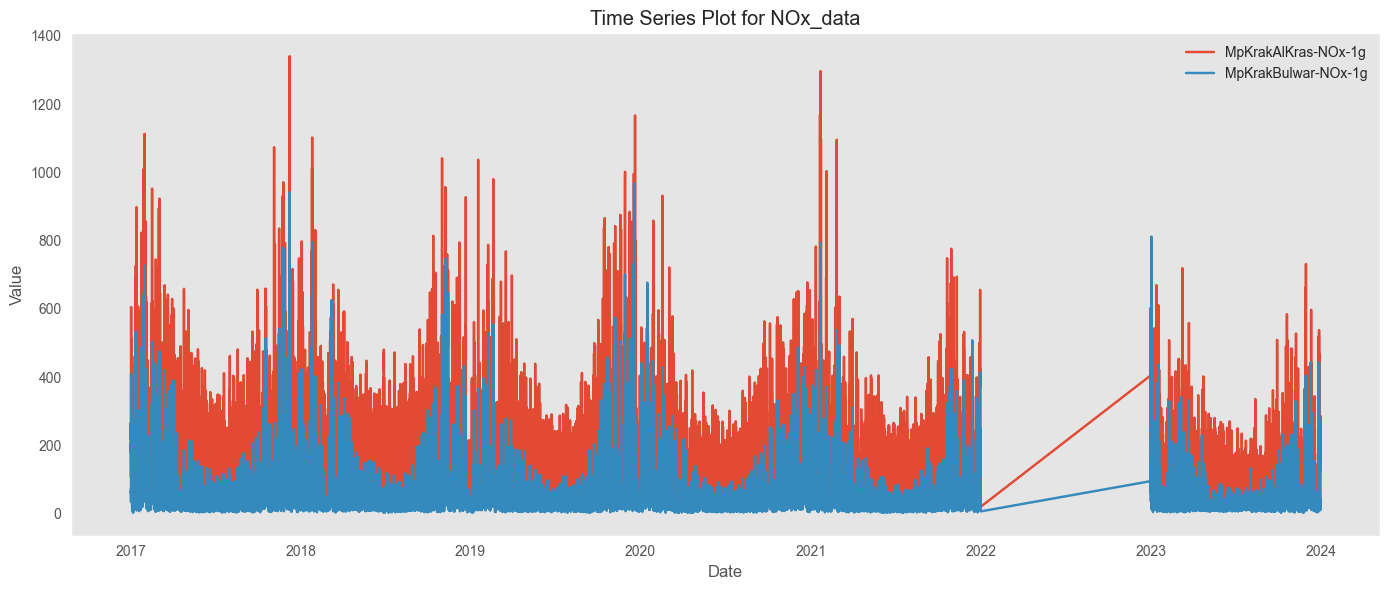

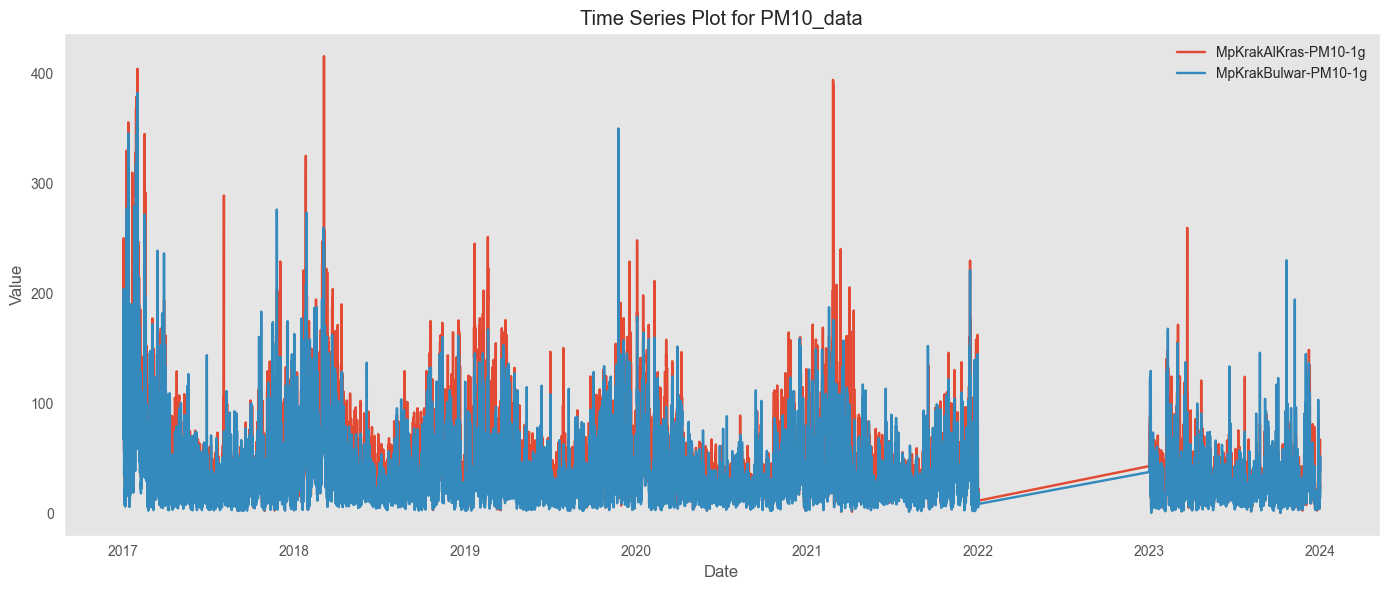

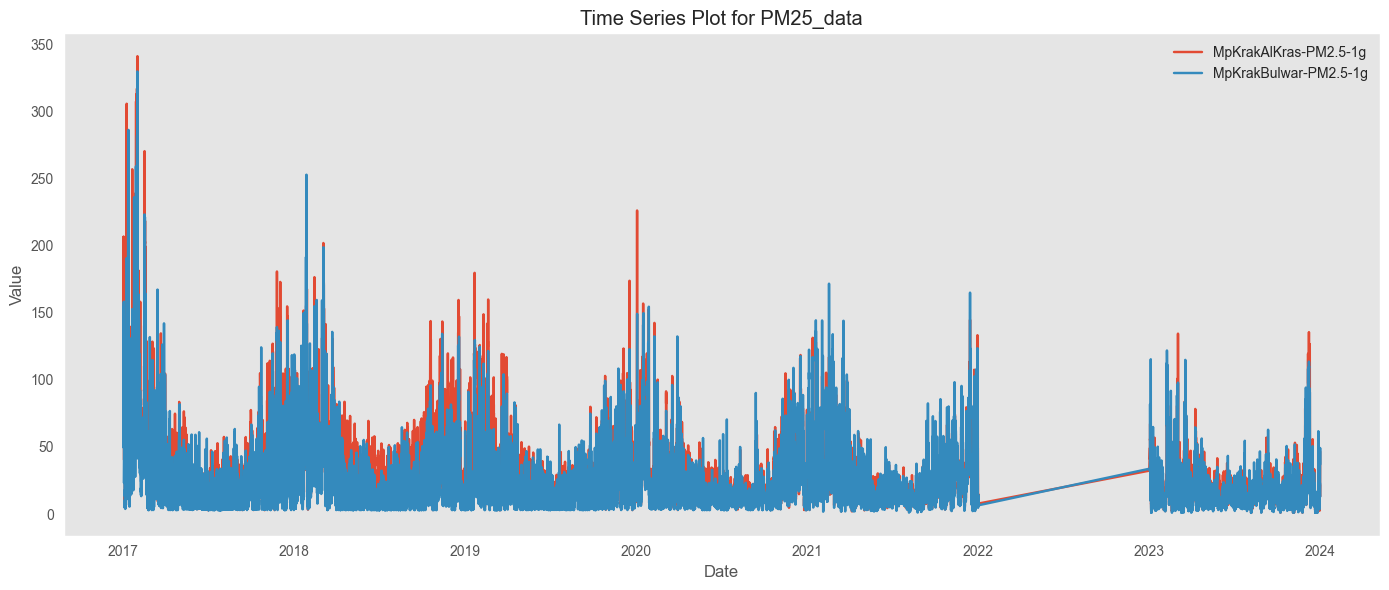

In [89]:
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_dir + file)
    
    data['date_column'] = pd.to_datetime(data['Time']) 
    data.set_index('date_column', inplace=True) 

    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    plt.figure(figsize=(14, 6))
    
    for col in krak_columns:
        plt.plot(data.index, data[col], label=col)
        
    plt.title(f'Time Series Plot for {name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    plt.show()

There seems to be a gap between 2022 and 2023, which could mean that for some reason, the entire year 2022 was not recorded. Therefore, we will focus our study on the period 01/01/2017 - 31/12/2021.

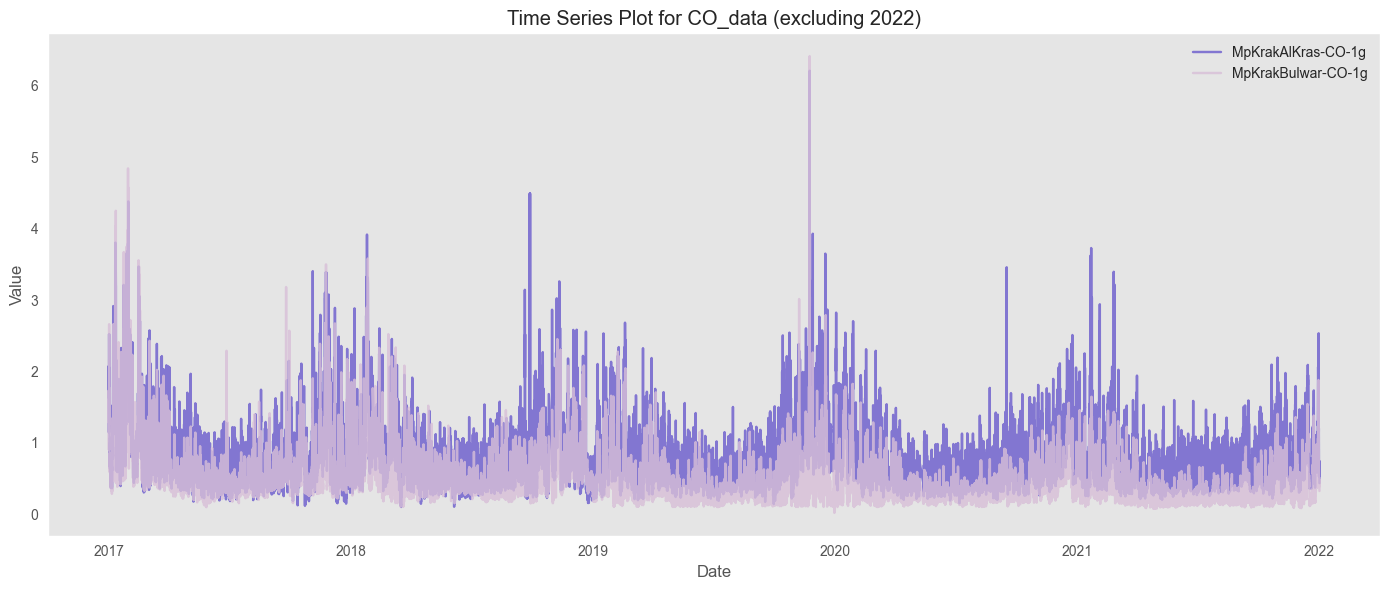

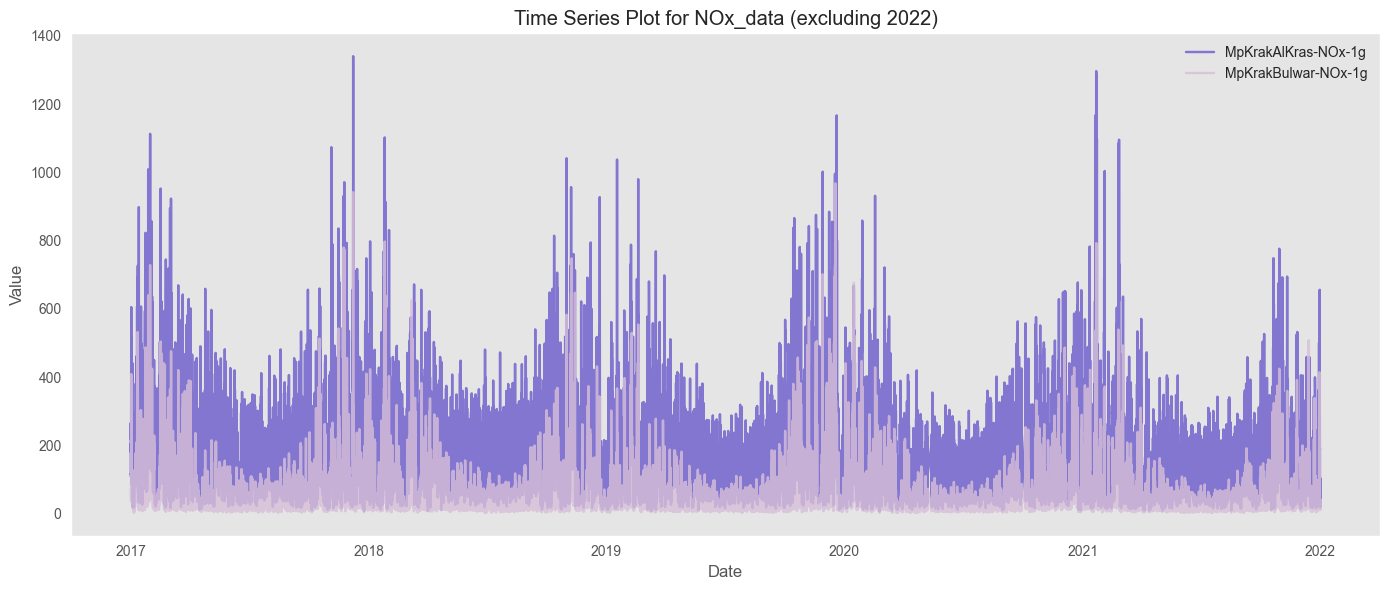

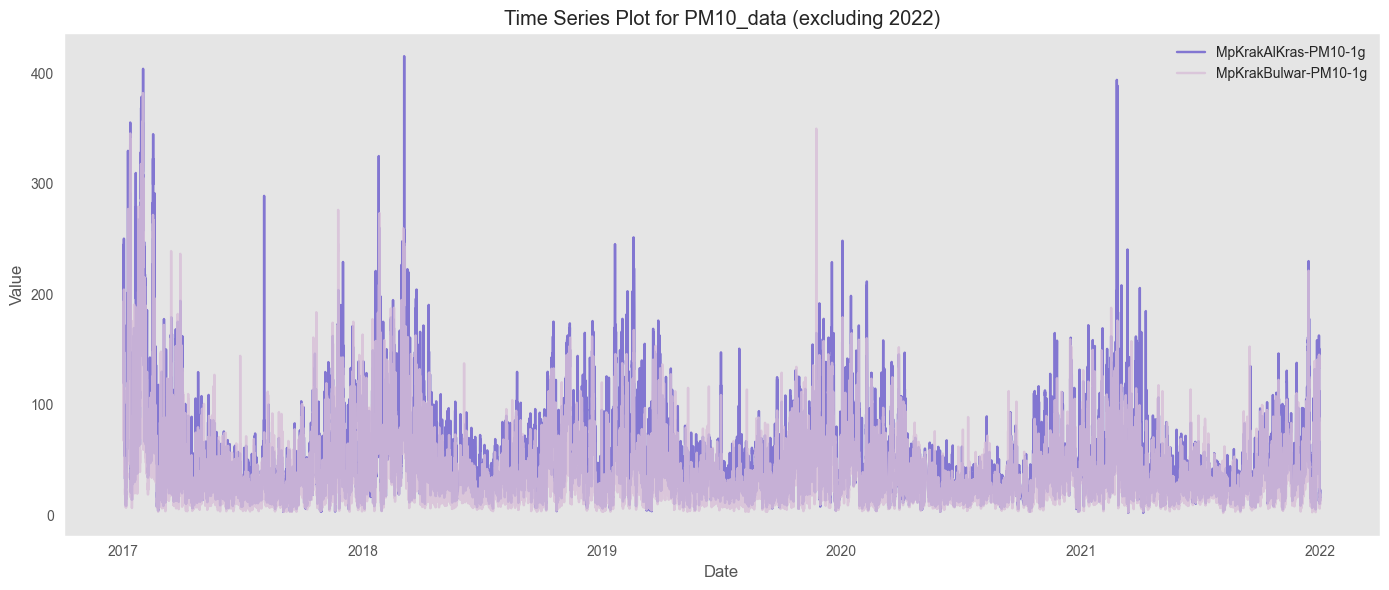

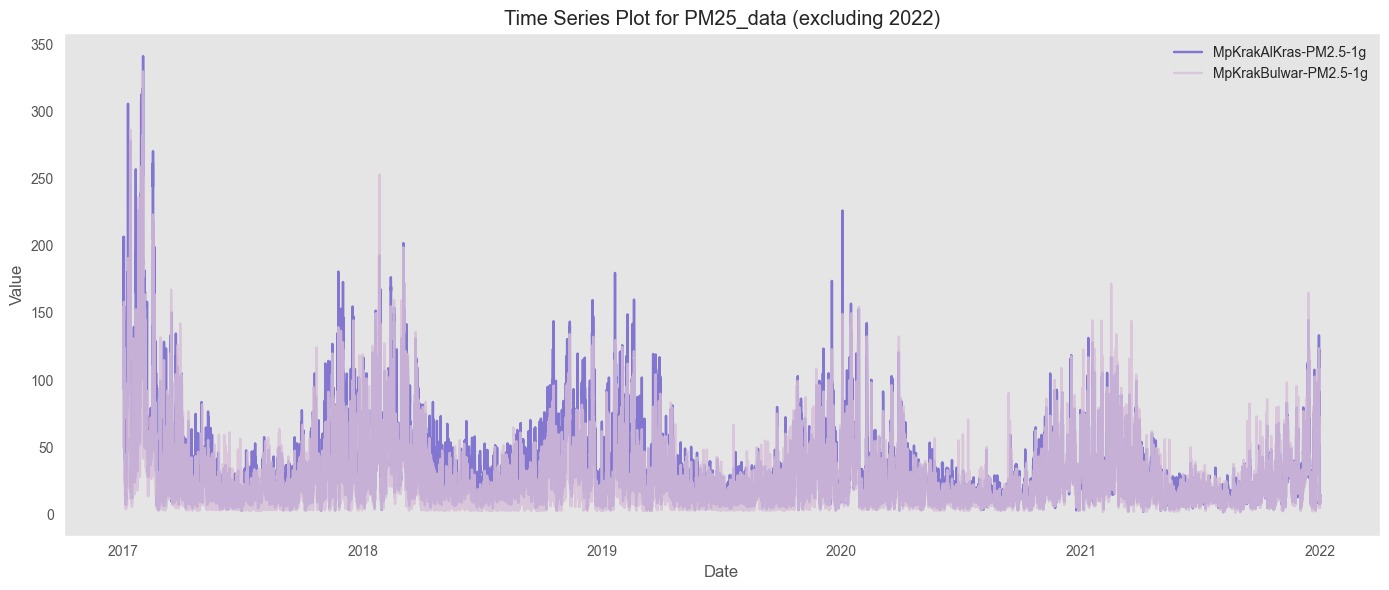

In [90]:
color_alkras = 'slateblue'
color_bulwar = 'thistle'
alpha_value = 0.8           # Set the desired alpha value (0 to 1)

# Loop through the cleaned datasets again for plotting
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_dir + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    plt.figure(figsize=(14, 6))
    
    for col in krak_columns:
        if 'MpKrakAlKras' in col:
            plt.plot(data.index, data[col], label=col, color=color_alkras, alpha=alpha_value)  # Use the first color with alpha
        elif 'MpKrakBulwar' in col:
            plt.plot(data.index, data[col], label=col, color=color_bulwar, alpha=alpha_value)  # Use the second color with alpha
        
    plt.title(f'Time Series Plot for {name} (excluding 2022)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    # Show the plot
    plt.show()

### Histograms

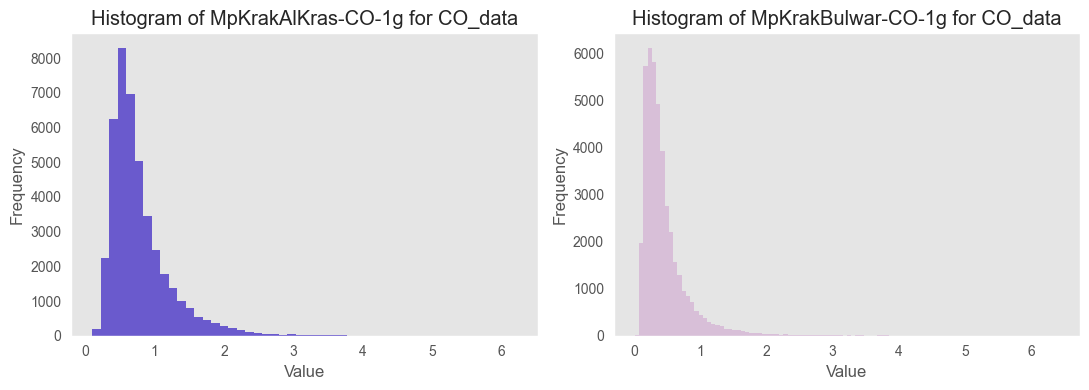

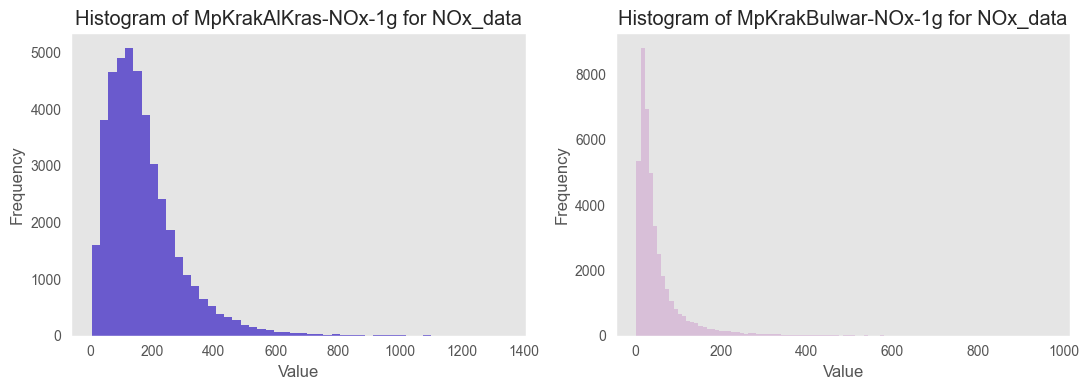

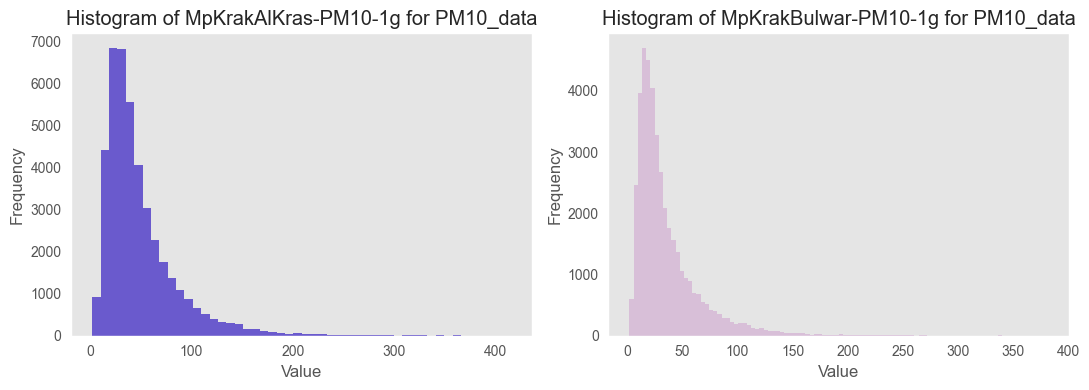

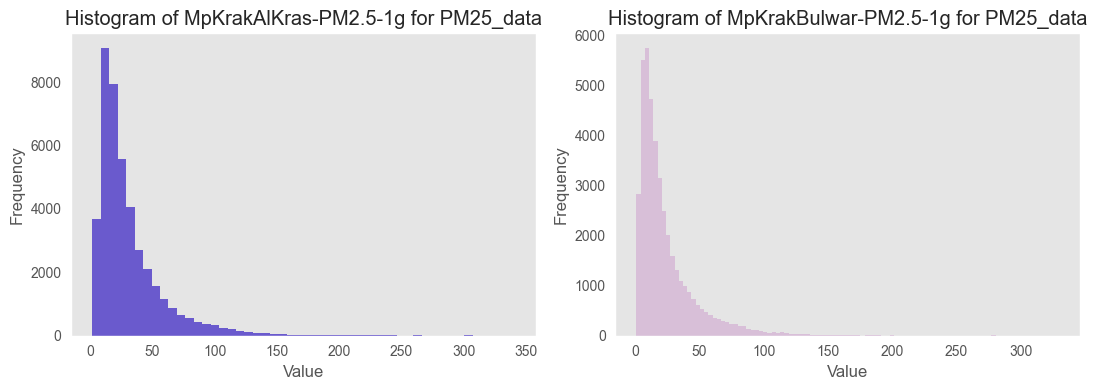

In [91]:
color_alkras = 'slateblue'       # Color for columns containing 'MpKrakAlKras'
color_kbulwar = 'thistle'  # Color for columns containing 'MpKrakBulwar'

for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_dir + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    # Create subplots for histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
    
    # Left plot for MpKrakAlKras
    for col in krak_columns:
        if 'MpKrakAlKras' in col:
            axes[0].hist(data[col], bins=50, alpha=1, color=color_alkras)  # Use smaller bins (50)
            axes[0].set_title(f'Histogram of {col} for {name}')
            axes[0].set_xlabel('Value')
            axes[0].set_ylabel('Frequency')
            axes[0].grid()

    # Right plot for MpKrakBulwar
    for col in krak_columns:
        if 'MpKrakBulwar' in col:
            axes[1].hist(data[col], bins=100, alpha=1, color=color_kbulwar)
            axes[1].set_title(f'Histogram of {col} for {name}')
            axes[1].set_xlabel('Value')
            axes[1].set_ylabel('Frequency')
            axes[1].grid()

    plt.tight_layout() 
    plt.show() 

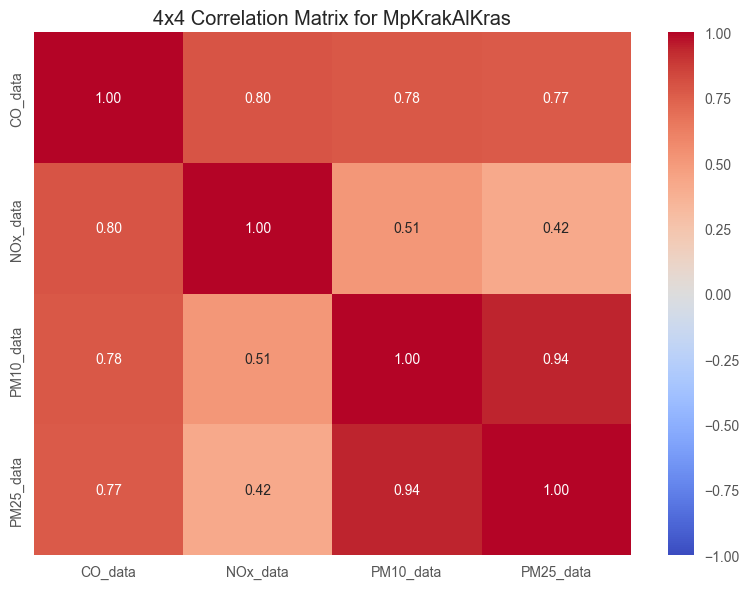

In [98]:
alkras_data = {}

# Loop through the cleaned datasets to extract the 'MpKrakAlKras' columns
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_dir + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    alkras_column = [col for col in data.columns if 'MpKrakAlKras' in col]
    
    if alkras_column:
        alkras_data[name] = data[alkras_column[0]].dropna()  # Drop NaN values

# Create a DataFrame for the correlation analysis
alkras_df = pd.DataFrame(alkras_data)

# Calculate the correlation matrix
correlation_matrix = alkras_df.corr()

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('4x4 Correlation Matrix for MpKrakAlKras')
plt.tight_layout()
plt.show()

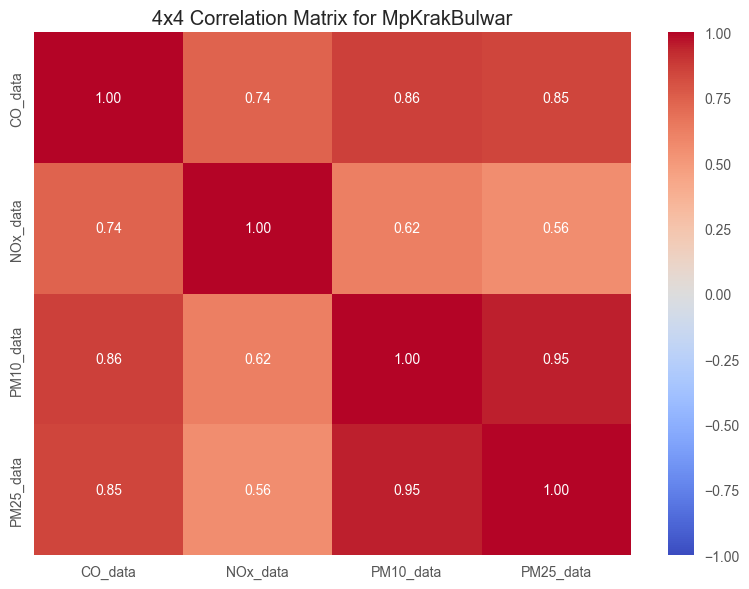

In [100]:
bulwar_data = {}

# Loop through the cleaned datasets to extract the 'MpKrakbulwar' columns
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_dir + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    bulwar_column = [col for col in data.columns if 'MpKrakBulwar' in col]
    
    if bulwar_column:
        bulwar_data[name] = data[bulwar_column[0]].dropna()  # Drop NaN values

# Create a DataFrame for the correlation analysis
bulwar_df = pd.DataFrame(bulwar_data)

# Calculate the correlation matrix
correlation_matrix = bulwar_df.corr()

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('4x4 Correlation Matrix for MpKrakBulwar')
plt.tight_layout()
plt.show()

Correlation matrix for CO_data:
                    MpKrakAlKras-CO-1g  MpKrakBulwar-CO-1g
MpKrakAlKras-CO-1g             1.00000             0.80729
MpKrakBulwar-CO-1g             0.80729             1.00000


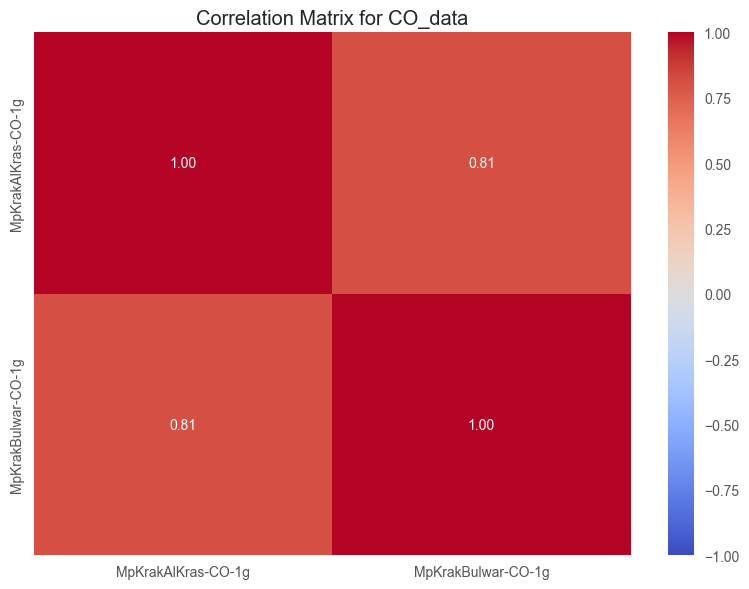

Correlation matrix for NOx_data:
                     MpKrakAlKras-NOx-1g  MpKrakBulwar-NOx-1g
MpKrakAlKras-NOx-1g             1.000000             0.692043
MpKrakBulwar-NOx-1g             0.692043             1.000000


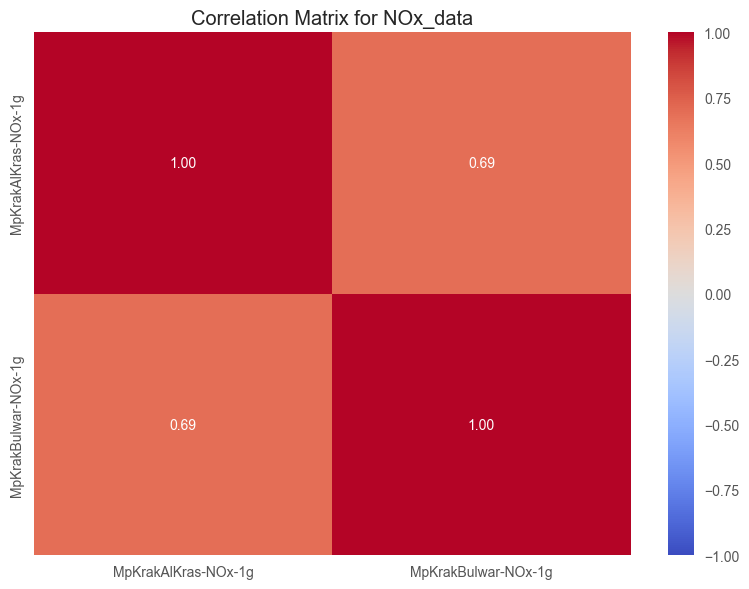

Correlation matrix for PM10_data:
                      MpKrakAlKras-PM10-1g  MpKrakBulwar-PM10-1g
MpKrakAlKras-PM10-1g              1.000000              0.870964
MpKrakBulwar-PM10-1g              0.870964              1.000000


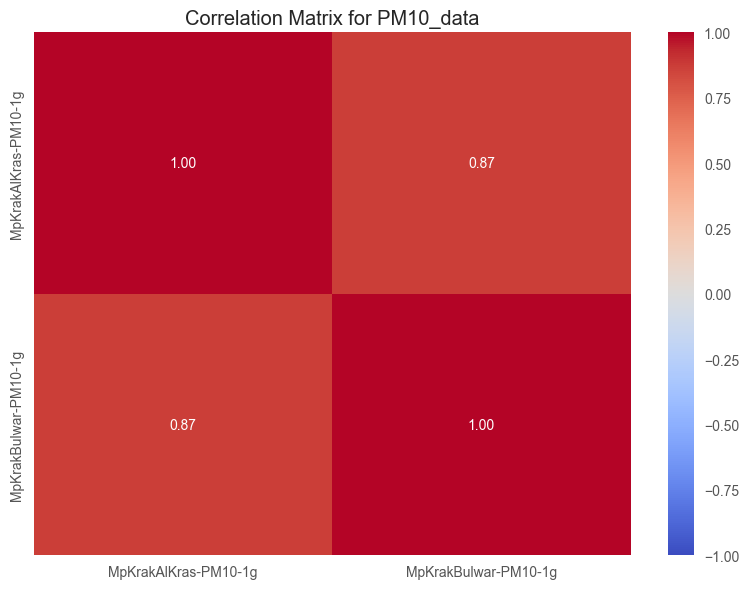

Correlation matrix for PM25_data:
                       MpKrakAlKras-PM2.5-1g  MpKrakBulwar-PM2.5-1g
MpKrakAlKras-PM2.5-1g               1.000000               0.903799
MpKrakBulwar-PM2.5-1g               0.903799               1.000000


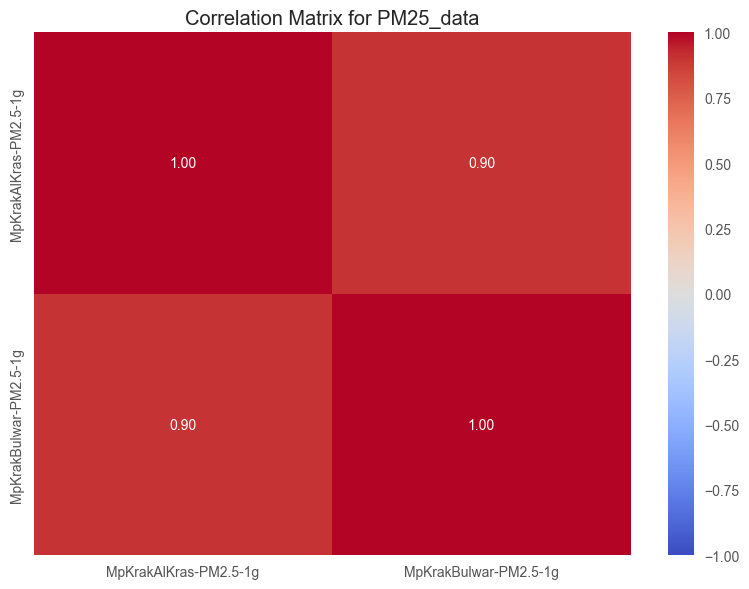

In [94]:
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_dir + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    # Identify columns of interest for correlation
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    # Calculate the correlation matrix
    correlation_matrix = data[krak_columns].corr()

    # Print the correlation coefficients
    print(f'Correlation matrix for {name}:')
    print(correlation_matrix)
    
    # Visualize the correlation matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {name}')
    plt.tight_layout()
    plt.show()

### Trends